<a href="https://colab.research.google.com/github/Anandraj-prog/Event-Ease/blob/main/Siamese_neural_network_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import os
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

In [ ]:
# 1. Extract the images
zip_file = '/content/drive/MyDrive/train.zip'
with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('train')



In [ ]:
# 2. Prepare the Dataset
def load_images(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            img = tf.keras.preprocessing.image.load_img(os.path.join(path, filename), target_size=(105, 105))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img /= 255.0
            images.append(img)
            #Corrected the label assignment logic to check if 'dog' is in filename
            labels.append(1 if 'dog' in filename else 0) # Corrected line
    return np.array(images), np.array(labels)

images, labels = load_images('./train/train')

# Create pairs of images
def create_pairs(images, labels):
    pairs, pair_labels = [], []
    num_classes = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(num_classes)]

    # Check if idx has at least two elements before accessing idx[1]
    if len(idx) >= 2:
        min_images = min(len(idx[0]), len(idx[1]))

        for i in range(min_images):
            # Positive pair
            img1, img2 = images[idx[0][i]], images[idx[0][(i + 1) % min_images]]
            pairs.append([img1, img2])
            pair_labels.append(1)

            # Negative pair
            img1, img2 = images[idx[0][i]], images[idx[1][i]]
            pairs.append([img1, img2])
            pair_labels.append(0)

        return np.array(pairs), np.array(pair_labels)
    else:
        # Handle the case where there are not enough classes
        print("Not enough classes found in the dataset.")
        return np.array([]), np.array([])

pairs, pair_labels = create_pairs(images, labels)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(pairs, pair_labels, test_size=0.2, random_state=42)

In [ ]:
# 3. Define the Siamese Network Architecture
def create_siamese_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (10,10), activation='relu',padding='same')(input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(64, (10,10), activation='relu')(x)
    x = layers.Conv2D(128, (7,7), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(128, (4,4), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(256, (4,4), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='sigmoid')(x)
    return Model(input, x)

input_shape = (105, 105, 3)
siamese_network = create_siamese_network(input_shape)

# Create the pairs input
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# Combine the two encoded inputs
encoded_a = siamese_network(input_a)
encoded_b = siamese_network(input_b)

# Calculate the distance between the embeddings
L1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([encoded_a, encoded_b])
output = layers.Dense(1, activation='sigmoid')(L1_distance)

model = Model([input_a, input_b], output)



In [ ]:
# 4. Train the Network 30min with TPU
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
                    batch_size=128, epochs=10)



Epoch 1/10
144/157 [==========================>...] - ETA: 50s - loss: 0.6944 - accuracy: 0.4983

KeyboardInterrupt: 

In [ ]:
# 5. Evaluate the Model
loss, accuracy = model.evaluate([X_val[:, 0], X_val[:, 1]], y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")



157/157 [==============================] - 14s 86ms/step - loss: 0.6932 - accuracy: 0.4984
Validation Loss: 0.6931548118591309, Validation Accuracy: 0.4984000027179718


In [ ]:
  # 6. Save the Model
  model.save('siamese_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


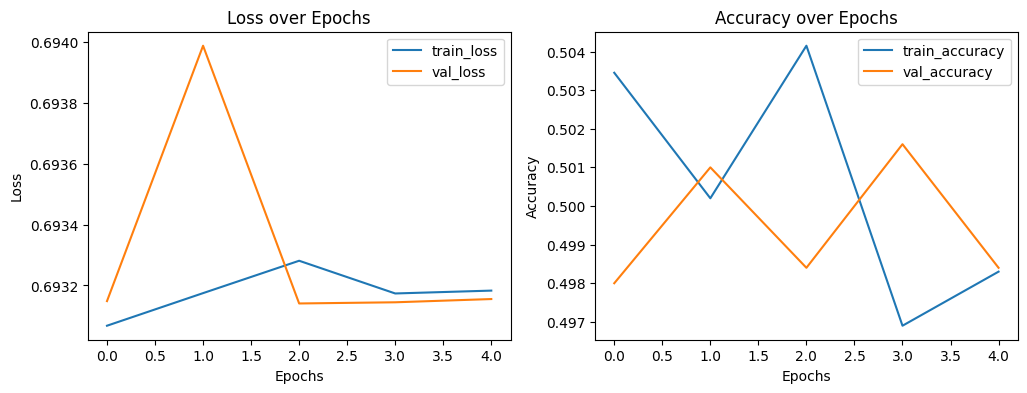

In [ ]:
# 1. Training and Validation Loss/Accuracy Over Epochs
import matplotlib.pyplot as plt
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Plot loss
    axs[0].plot(history.history['loss'], label='train_loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label='train_accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].set_title('Accuracy over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

plot_training_history(history)

1/1 [==============================] - 0s 46ms/step


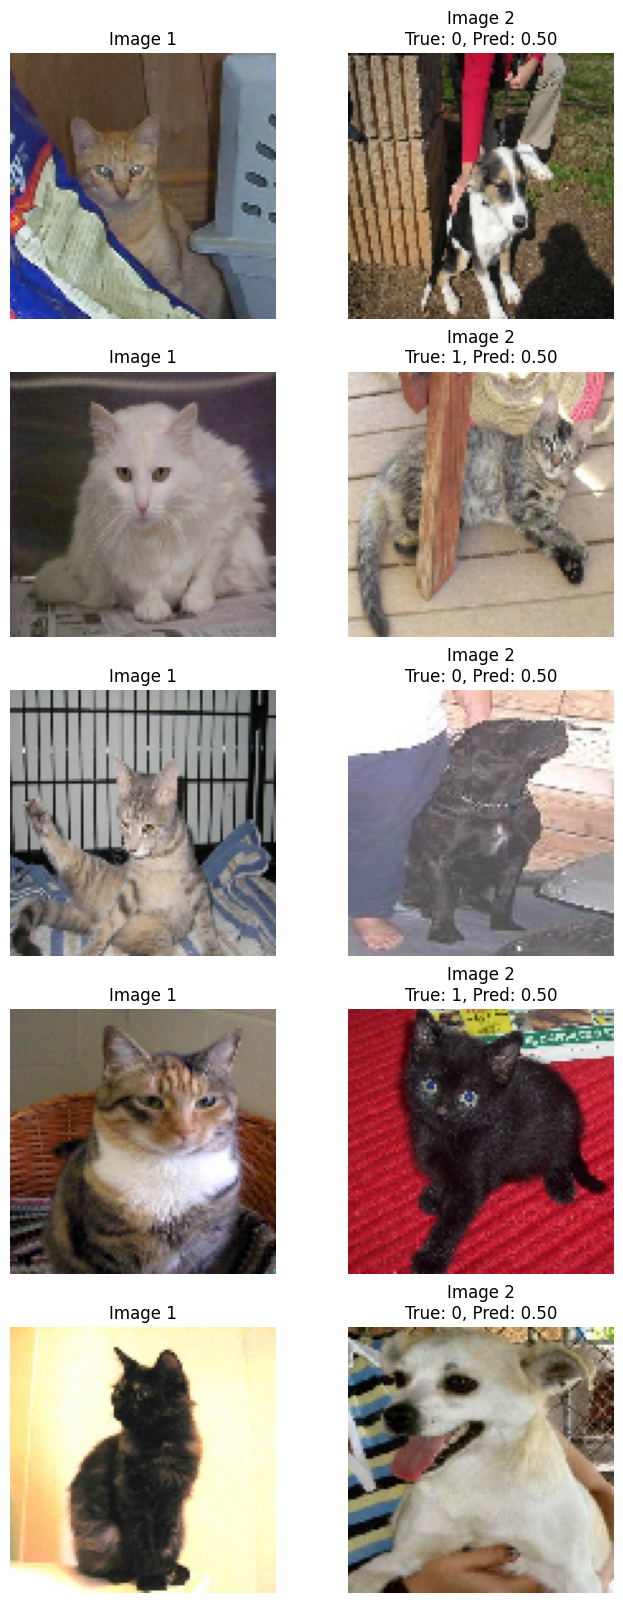

In [ ]:
# 2. Sample Image Pairs with Predictions
def plot_sample_predictions(model, pairs, labels):
    num_samples = 5
    fig, axs = plt.subplots(num_samples, 2, figsize=(8, num_samples*4))

    for i in range(num_samples):
        idx = np.random.randint(0, len(pairs))
        pair = pairs[idx]
        label = labels[idx]

        prediction = model.predict([pair[0:1], pair[1:2]])[0][0]
        axs[i, 0].imshow(pair[0])
        axs[i, 0].set_title('Image 1')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(pair[1])
        axs[i, 1].set_title(f'Image 2\nTrue: {label}, Pred: {prediction:.2f}')
        axs[i, 1].axis('off')

    plt.show()

plot_sample_predictions(model, X_val, y_val)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 46ms/step


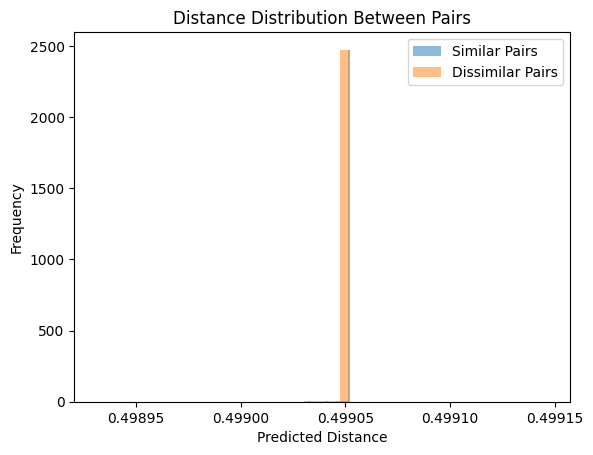

In [ ]:
# 3. Distance Distribution Between Pairs
def plot_distance_distribution(model, pairs, labels):
    distances = []
    for i in range(len(pairs)):
        pair = pairs[i]
        prediction = model.predict([pair[0:1], pair[1:2]])
        prediction = prediction[0][0]
        distances.append(prediction)

    distances = np.array(distances)
    plt.hist(distances[labels == 1], bins=50, alpha=0.5, label='Similar Pairs')
    plt.hist(distances[labels == 0], bins=50, alpha=0.5, label='Dissimilar Pairs')
    plt.title('Distance Distribution Between Pairs')
    plt.xlabel('Predicted Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_distance_distribution(model, X_val, y_val)